# Import Necessary Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE


# Load Data

In [2]:
df = pd.read_excel("C:\\Users\\akhil\\Downloads\\fraud_data.xlsx")

In [3]:
df.head()

,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud
0,1,375.17,47605,Houston,Travel,18.0,0
1,2,950.76,38088,Los Angeles,Electronics,28.0,0
2,3,732.26,78752,Miami,Travel,20.0,0
3,4,599.06,55284,New York,Groceries,69.0,0
4,5,156.86,57043,New York,Groceries,79.0,0


In [4]:
df.shape

(500, 7)

In [5]:
df.columns

Index(['TransactionID', 'Amount', 'Time', 'Location', 'MerchantCategory',
       'CardHolderAge', 'IsFraud'],
      dtype='object')

In [6]:
df.dtypes

TransactionID         int64
Amount              float64
Time                  int64
Location             object
MerchantCategory     object
CardHolderAge       float64
IsFraud               int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TransactionID     500 non-null    int64  
 1   Amount            475 non-null    float64
 2   Time              500 non-null    int64  
 3   Location          475 non-null    object 
 4   MerchantCategory  500 non-null    object 
 5   CardHolderAge     476 non-null    float64
 6   IsFraud           500 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 27.5+ KB


In [8]:
df.describe()

,TransactionID,Amount,Time,CardHolderAge,IsFraud
count,500.000000,475.000000,500.000000,476.000000,500.000000
mean,250.500000,641.112753,41141.482000,47.518908,0.054000
std,144.481833,1044.448065,25614.468967,18.677362,0.226244
min,1.000000,6.060000,55.000000,5.000000,0.000000
25%,125.750000,243.780000,18726.250000,32.000000,0.000000
50%,250.500000,518.810000,40772.000000,47.000000,0.000000
75%,375.250000,776.000000,63463.250000,63.000000,0.000000
max,500.000000,9691.578643,86066.000000,120.000000,1.000000


In [9]:
df.isnull().sum()

TransactionID        0
Amount              25
Time                 0
Location            25
MerchantCategory     0
CardHolderAge       24
IsFraud              0
dtype: int64

In [10]:
df = df.drop(columns=["TransactionID"])  

In [11]:
X = df.drop("IsFraud", axis=1)
y = df["IsFraud"]

In [12]:
numeric_features = ["Amount", "Time", "CardHolderAge"]
categorical_features = ["Location", "MerchantCategory"]

# Preprocessing

In [13]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)])

# Train Test Split


In [14]:
X_processed = preprocessor.fit_transform(X)
y_array = np.array(y)

In [15]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y_array)


C:\Users\akhil\anaconda3\envs\env_2\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)


# Models

# Logistic Regression


In [17]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

In [18]:
rf = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [20]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
def print_metrics(model_name, y_true, y_pred, y_prob):
    print(f"\n===== {model_name} =====")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("ROC-AUC:", round(roc_auc_score(y_true, y_prob), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

# 12. Print Results
print_metrics("Logistic Regression (SMOTE)", y_test, y_pred_lr, y_prob_lr)
print_metrics("Random Forest (SMOTE)", y_test, y_pred_rf, y_prob_rf)


===== Logistic Regression (SMOTE) =====
Accuracy: 0.5684
ROC-AUC: 0.6308
Confusion Matrix:
 [[54 41]
 [41 54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57        95
           1       0.57      0.57      0.57        95

    accuracy                           0.57       190
   macro avg       0.57      0.57      0.57       190
weighted avg       0.57      0.57      0.57       190


===== Random Forest (SMOTE) =====
Accuracy: 0.9526
ROC-AUC: 0.9939
Confusion Matrix:
 [[91  4]
 [ 5 90]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        95
           1       0.96      0.95      0.95        95

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190



In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

C:\Users\akhil\AppData\Local\Temp\ipykernel_31820\4226938931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="IsFraud", data=df, palette="coolwarm")


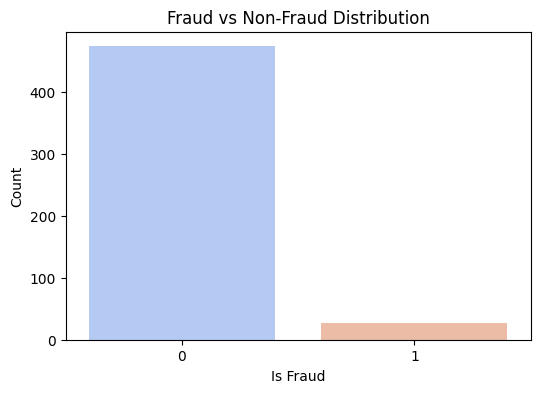

In [23]:
# Fraud vs Non-Fraud Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="IsFraud", data=df, palette="coolwarm")
plt.title("Fraud vs Non-Fraud Distribution")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.show()

C:\Users\akhil\AppData\Local\Temp\ipykernel_31820\3503738978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="IsFraud", y="Amount", data=df, palette="coolwarm")


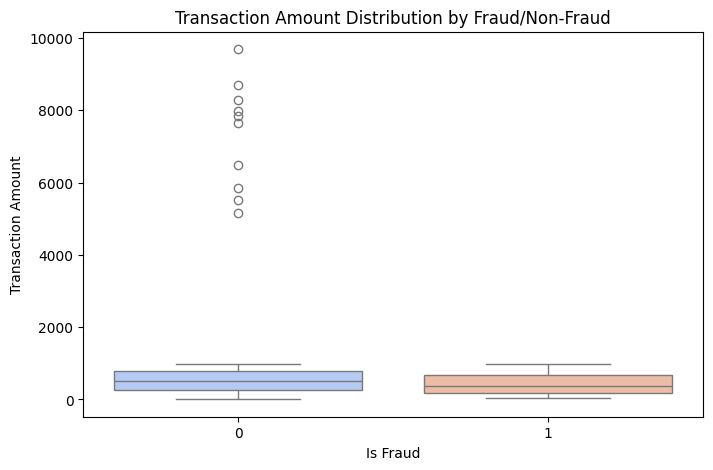

In [25]:
# Transaction Amount Distribution
plt.figure(figsize=(8,5))
sns.boxplot(x="IsFraud", y="Amount", data=df, palette="coolwarm")
plt.title("Transaction Amount Distribution by Fraud/Non-Fraud")
plt.xlabel("Is Fraud")
plt.ylabel("Transaction Amount")
plt.show()


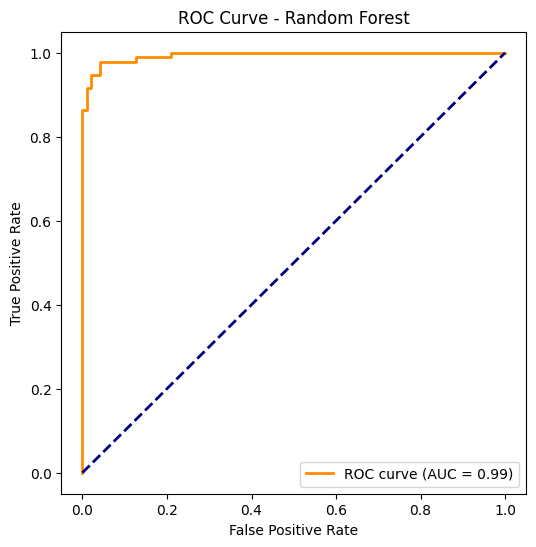

In [26]:
# ROC Curve (Random Forest)
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

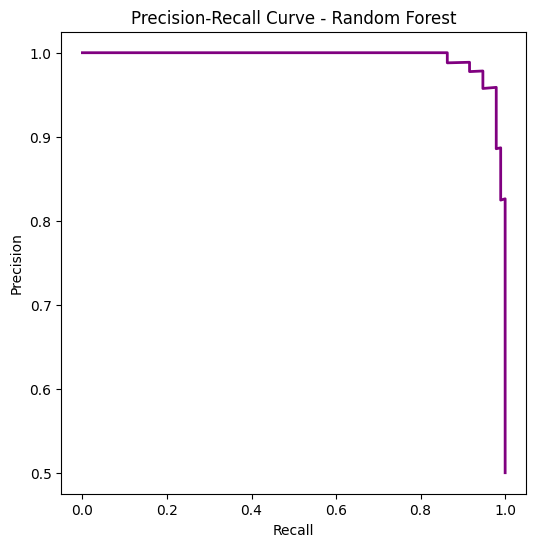

In [27]:
# Precision-Recall Curve (Random Forest)
precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color="purple", lw=2)
plt.title("Precision-Recall Curve - Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()
